# **Homework 1: Linear Regression**

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [1]:
import sys
import pandas as pd
import numpy as np
data = pd.read_csv('./../data/train.csv', encoding = 'big5')

# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [2]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [3]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [4]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

# **Normalize (1)**


In [5]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [6]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [7]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

0:27.071214829194115
100:33.78905859777455
200:19.913751298197102
300:13.531068193689693
400:10.64546615844617
500:9.277353455475062
600:8.518042045956497
700:8.014061987588418
800:7.636756824775688
900:7.336563740371121


# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [8]:
testdata = pd.read_csv('./../data/test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [9]:
# w = np.load('./../model/weight.npy')
ans_y = np.dot(test_x, w)
ans_y

array([[ 5.17496040e+00],
       [ 1.83062143e+01],
       [ 2.04912181e+01],
       [ 1.15239429e+01],
       [ 2.66160568e+01],
       [ 2.05313481e+01],
       [ 2.19065510e+01],
       [ 3.17364687e+01],
       [ 1.33916741e+01],
       [ 6.44564665e+01],
       [ 2.02645688e+01],
       [ 1.53585761e+01],
       [ 6.85894728e+01],
       [ 4.84281137e+01],
       [ 1.87023338e+01],
       [ 1.01885957e+01],
       [ 3.07403629e+01],
       [ 7.11322178e+01],
       [-4.13051739e+00],
       [ 1.82356940e+01],
       [ 3.85789223e+01],
       [ 7.13115197e+01],
       [ 7.41034816e+00],
       [ 1.87179553e+01],
       [ 1.49372503e+01],
       [ 3.67197367e+01],
       [ 1.79616970e+01],
       [ 7.57894629e+01],
       [ 1.23093102e+01],
       [ 5.62953517e+01],
       [ 2.51131609e+01],
       [ 4.61024867e+00],
       [ 2.48377055e+00],
       [ 2.47594223e+01],
       [ 3.04802805e+01],
       [ 3.84639307e+01],
       [ 4.42023106e+01],
       [ 3.00868360e+01],
       [ 4.0

# **Save Prediction to CSV File**


In [10]:
import csv
# with open('./../results/submit.csv', mode='w', newline='') as submit_file:
#     csv_writer = csv.writer(submit_file)
#     header = ['id', 'value']
#     print(header)
#     csv_writer.writerow(header)
#     for i in range(240):
#         row = ['id_' + str(i), ans_y[i][0]]
#         csv_writer.writerow(row)
#         print(row)

---
# Homework1 report 

## Problem1

### 使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

In [11]:
import matplotlib.pyplot as plt

In [12]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
# Normalize
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

In [21]:
learning_rate_list = [10**power for power in range(-1,3)]
loss_history = []
validation_loss_history = []
dim = 18 * 9 + 1
iter_time = 1000
eps = 0.0000000001
for lr in learning_rate_list:
    print("Use learning rate:", lr)
    history = []
    validation_history = []
    w = np.zeros([dim, 1])
    temp_x = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set), axis = 1).astype(float)
    temp_x_validation = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation), axis = 1).astype(float)
    learning_rate = lr
    adagrad = np.zeros([dim, 1])
    for t in range(iter_time):
        loss = np.sqrt(np.sum(np.power(np.dot(temp_x, w) - y_train_set, 2))/471/12)#rmse
        history.append(loss)
        validation_loss = np.sqrt(np.sum(np.power(np.dot(temp_x_validation, w) - y_validation, 2))/471/12)#rmse
        validation_history.append(validation_loss)
        if(t%100==0):
            print(str(t) + ":" + str(loss))
        gradient = 2 * np.dot(temp_x.transpose(), np.dot(temp_x, w) - y_train_set) #dim*1
        adagrad += gradient ** 2
        w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
    loss_history.append(history)
    validation_loss_history.append(validation_history)
loss_history = np.array(loss_history)
validation_loss_history = np.array(validation_loss_history)

Use learning rate: 0.1
0:24.36221492236629
100:18.90834718964592
200:18.053295995106758
300:17.45994247298926
400:16.986116293318467
500:16.58315001985104
600:16.22806970576931
700:15.90810665089768
800:15.615360265000144
900:15.344546182518075
Use learning rate: 1
0:24.36221492236629
100:8.594232164442651
200:6.42786842526481
300:5.768784999762439
400:5.539097149109682
500:5.435245092394387
600:5.373948969208427
700:5.3310670370490545
800:5.298374502137377
900:5.272337327984913
Use learning rate: 10
0:24.36221492236629
100:6.561283208061513
200:5.887833132356353
300:5.656016404097853
400:5.531232340650519
500:5.4505480582001535
600:5.393304198965543
700:5.350350328775729
800:5.31685726009195
900:5.289986029498695
Use learning rate: 100
0:24.36221492236629
100:20.323593225645208
200:9.326264559340517
300:6.829236149377325
400:6.126311241297732
500:5.829997137753873
600:5.657451772718694
700:5.540029134523291
800:5.454822077702425
900:5.391104701661771


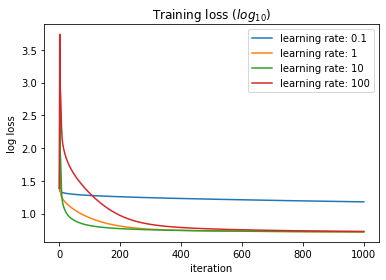

In [24]:
for i in range(loss_history.shape[0]):
    plt.plot(
        np.arange(loss_history.shape[1])+1,
        np.log10(loss_history[i,:]),
        label = 'learning rate: ' + str(learning_rate_list[i])
    )
plt.legend()
plt.title('Training loss $(log_{10})$')
plt.xlabel('iteration')
plt.ylabel('log loss')
plt.savefig('./../report/training_loss.png')

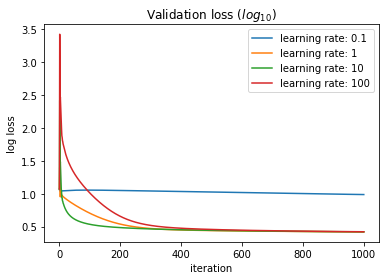

In [25]:
for i in range(validation_loss_history.shape[0]):
    plt.plot(
        np.arange(validation_loss_history.shape[1])+1,
        np.log10(validation_loss_history[i,:]),
        label = 'learning rate: ' + str(learning_rate_list[i])
    )
plt.legend()
plt.title('Validation loss $(log_{10})$')
plt.xlabel('iteration')
plt.ylabel('log loss')
plt.savefig('./../report/validation_loss.png')

## 9 hrs

In [47]:
dim = 18 * 9 + 1
iter_time = 5000
learning_rate = 10
eps = 0.0000000001

history = []
validation_history = []
w = np.zeros([dim, 1])

temp_x = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set), axis = 1).astype(float)
temp_x_validation = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation), axis = 1).astype(float)
adagrad = np.zeros([dim, 1])

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(temp_x, w) - y_train_set, 2))/471/12)#rmse
    history.append(loss)
    validation_loss = np.sqrt(np.sum(np.power(np.dot(temp_x_validation, w) - y_validation, 2))/471/12)#rmse
    validation_history.append(validation_loss)
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(temp_x.transpose(), np.dot(temp_x, w) - y_train_set) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

0:24.36221492236629
100:6.561283208061513
200:5.887833132356353
300:5.656016404097853
400:5.531232340650519
500:5.4505480582001535
600:5.393304198965543
700:5.350350328775729
800:5.31685726009195
900:5.289986029498695
1000:5.2679462025148736
1100:5.249550755112938
1200:5.233981460522808
1300:5.220655648110694
1400:5.2091464357172494
1500:5.1991330518184995
1600:5.190368907825238
1700:5.182660526904414
1800:5.175853309093097
1900:5.169821707812071
2000:5.164462314419491
2100:5.159688896959885
2200:5.155428775668116
2300:5.151620128361646
2400:5.148209953222162
2500:5.145152503673816
2600:5.142408067533805
2700:5.13994200101791
2800:5.1377239541921345
2900:5.135727242297439
3000:5.133928329756446
3100:5.132306402370309
3200:5.130843009398912
3300:5.129521761666827
3400:5.128328075075714
3500:5.127248951288017
3600:5.126272789122503
3700:5.125389221539428
3800:5.124588974111472
3900:5.123863741660422
4000:5.123206080349178
4100:5.12260931299756
4200:5.122067445770268
4300:5.12157509468938

## 5 hr

In [48]:
temp = np.full([9,], False)
temp[-5:] = True
pick_features = np.copy(temp)
for i in range(17):
    pick_features = np.append(pick_features, temp)
pick_features.shape

(162,)

In [49]:
dim = 18 * 5 + 1
iter_time = 5000
learning_rate = 10
eps = 0.0000000001

history_5hr = []
validation_history_5hr = []
w_5hr = np.zeros([dim, 1])

temp_x = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set.T[pick_features].T), axis = 1).astype(float)
temp_x_validation = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation.T[pick_features].T), axis = 1).astype(float)
adagrad = np.zeros([dim, 1])

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(temp_x, w_5hr) - y_train_set, 2))/471/12)#rmse
    history_5hr.append(loss)
    validation_loss = np.sqrt(np.sum(np.power(np.dot(temp_x_validation, w_5hr) - y_validation, 2))/471/12)#rmse
    validation_history_5hr.append(validation_loss)
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(temp_x.transpose(), np.dot(temp_x, w_5hr) - y_train_set) #dim*1
    adagrad += gradient ** 2
    w_5hr = w_5hr - learning_rate * gradient / np.sqrt(adagrad + eps)

0:24.36221492236629
100:5.978724401676715
200:5.625032173888488
300:5.479493561223028
400:5.403266243287307
500:5.357811075797966
600:5.328544155473333
700:5.308812544420462
800:5.295119961515279
900:5.285432096563821
1000:5.278480224368032
1100:5.273435720885109
1200:5.269740444950305
1300:5.267010368694381
1400:5.264977167255098
1500:5.26345113400393
1600:5.26229685265597
1700:5.2614168637891865
1800:5.260740511887482
1900:5.260216231063947
2000:5.259806153713256
2100:5.259482309451646
2200:5.259223924445595
2300:5.259015489008302
2400:5.258845365834899
2500:5.258704781434092
2600:5.258587090985712
2700:5.258487239533229
2800:5.258401365002973
2900:5.25832650426137
3000:5.2582603744381675
3100:5.258201209514294
3200:5.258147637688264
3300:5.258098588972802
3400:5.258053225301186
3500:5.258010887464839
3600:5.257971054686128
3700:5.257933313712151
3800:5.257897335108486
3900:5.25786285501626
4000:5.2578296610683335
4100:5.257797581481633
4200:5.257766476582382
4300:5.257736232200428
4

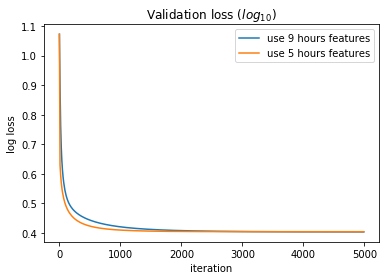

In [61]:
idx = 5000
step = 10

plt.plot(
    np.arange(len(validation_history))[:idx:step]+1,
    np.log10(validation_history)[:idx:step],
    label = 'use 9 hours features'
)
plt.plot(
    np.arange(len(validation_history_5hr))[:idx:step]+1,
    np.log10(validation_history_5hr[:idx:step]),
    label = 'use 5 hours features'
)
plt.legend()
plt.title('Validation loss $(log_{10})$')
plt.xlabel('iteration')
plt.ylabel('log loss')
plt.savefig('./../report/loss_9hr_vs_5hr.png')

In [62]:
min(validation_history_5hr), min(validation_history), min(validation_history_5hr) > min(validation_history)

(2.5384974754601943, 2.534209797552292, True)

## Train with using only PM2.5 and all features (9 hours)

In [64]:
pick_features = np.full([18 * 9,], False)
pick_features[9*9:10*9] = True
pick_features.shape

(162,)

In [66]:
dim = 9 + 1
iter_time = 5000
learning_rate = 10
eps = 0.0000000001

history_PM25 = []
validation_history_PM25 = []
w_PM25 = np.zeros([dim, 1])

temp_x = np.concatenate((np.ones([x_train_set.shape[0], 1]), x_train_set.T[pick_features].T), axis = 1).astype(float)
temp_x_validation = np.concatenate((np.ones([x_validation.shape[0], 1]), x_validation.T[pick_features].T), axis = 1).astype(float)
adagrad = np.zeros([dim, 1])

for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(temp_x, w_PM25) - y_train_set, 2))/471/12)#rmse
    history_PM25.append(loss)
    validation_loss = np.sqrt(np.sum(np.power(np.dot(temp_x_validation, w_PM25) - y_validation, 2))/471/12)#rmse
    validation_history_PM25.append(validation_loss)
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(temp_x.transpose(), np.dot(temp_x, w_PM25) - y_train_set) #dim*1
    adagrad += gradient ** 2
    w_PM25 = w_PM25 - learning_rate * gradient / np.sqrt(adagrad + eps)

0:24.36221492236629
100:5.752118183125287
200:5.613806928209706
300:5.568934035410149
400:5.551603394664598
500:5.544621880774884
600:5.541764753651903
700:5.540585850683125
800:5.540096434059089
900:5.539892059204015
1000:5.539806174891635
1100:5.539769830770611
1200:5.539754331304894
1300:5.539747665016923
1400:5.539744771491962
1500:5.539743503301682
1600:5.539742941836038
1700:5.539742690689407
1800:5.539742577190875
1900:5.539742525380686
2000:5.539742501501305
2100:5.539742490395092
2200:5.539742485186209
2300:5.539742482724559
2400:5.5397424815532705
2500:5.539742480992596
2600:5.5397424807228
2700:5.539742480592387
2800:5.539742480529103
2900:5.539742480498293
3000:5.539742480483253
3100:5.539742480475892
3200:5.539742480472284
3300:5.539742480470512
3400:5.5397424804696405
3500:5.5397424804692115
3600:5.539742480469
3700:5.539742480468896
3800:5.539742480468845
3900:5.539742480468819
4000:5.5397424804688065
4100:5.539742480468801
4200:5.539742480468798
4300:5.539742480468796
4

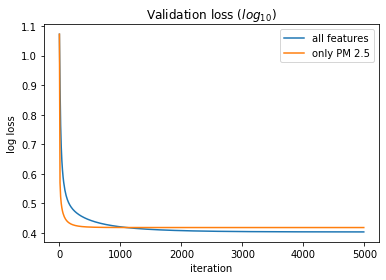

In [68]:
idx = 5000
step = 10

plt.plot(
    np.arange(len(validation_history))[:idx:step]+1,
    np.log10(validation_history)[:idx:step],
    label = 'all features'
)
plt.plot(
    np.arange(len(validation_history_PM25))[:idx:step]+1,
    np.log10(validation_history_PM25[:idx:step]),
    label = 'only PM 2.5'
)
plt.legend()
plt.title('Validation loss $(log_{10})$')
plt.xlabel('iteration')
plt.ylabel('log loss')
plt.savefig('./../report/loss_pm25_vs_all.png')

In [69]:
min(validation_history_PM25), min(validation_history), min(validation_history_PM25) > min(validation_history)

(2.6218562828710685, 2.534209797552292, True)

### Predict

In [ ]:
# w = np.load('./../model/weight2.npy')
# ans_y = np.dot(test_x, w)
# ans_y

### Save

In [ ]:
# import csv
# with open('./../results/submit2.csv', mode='w', newline='') as submit_file:
#     csv_writer = csv.writer(submit_file)
#     header = ['id', 'value']
#     print(header)
#     csv_writer.writerow(header)
#     for i in range(240):
#         row = ['id_' + str(i), ans_y[i][0]]
#         csv_writer.writerow(row)
#         print(row)